# Minimal Genome Inference

## Introduction

Use comparative genomics to determine which elements of the genomes are highly conserved.

We will assume that all highly conserved elements are essential.

Subset the genome down to these essential sequences, and reconstruct a new path through the genome that will minimize the size to only include these regions of the genome that are inferred essential.

## Methods

Pseudo-algorithm:
- pull list of all genomes on NCBI
- build pangenome
- filter out dna sequences with low conservation
- walk shortest/maximum likelihood path(s)

In [5]:
DATE = "2022-01-15"
TASK = "minimal-genome"
DIR = mkpath("$(homedir())/workspace/$(DATE)-$(TASK)")
cd(DIR)

In [6]:
pkgs = [
"Graphs",
"MetaGraphs",
"BioSequences",
"uCSV",
"DataFrames",
"FASTX",
"HTTP",
"CodecZlib",
"Revise",
"FileIO",
"JLD2",
"StatsPlots",
"ProgressMeter"
]

import Pkg
Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $(basename(pkg))"))
end

import Mycelia

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/.julia/dev/Mycelia/docs/Project.toml`
  No Changes to `~/.julia/dev/Mycelia/docs/Manifest.toml`
┌ Info: Precompiling Mycelia [453d265d-8292-4a7b-a57c-dce3f9ae6acd]
└ @ Base loading.jl:1342


### Virus: COVID-19

In [7]:
# all nucleotide records
# https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=SARS-CoV-2,%20taxid:2697049

In [8]:
# accession list downloaded from
# https://www.ncbi.nlm.nih.gov/sars-cov-2/
covid_accessions = DataFrames.DataFrame(uCSV.read(joinpath(Mycelia.METADATA, "sars-cov-2-accession-list.txt"), header=1)...)[!, "id"]

10000-element Vector{String}:
 "MW592645"
 "MW592651"
 "MZ504055"
 "MZ500902"
 "MZ501473"
 "MZ501471"
 "MZ500800"
 "MW590397"
 "MW592612"
 "MW592636"
 "MZ500802"
 "MZ500903"
 "MZ504037"
 ⋮
 "MZ497191"
 "MZ473712"
 "MZ473745"
 "MZ433955"
 "MZ350108"
 "MZ350111"
 "MZ473755"
 "MZ434008"
 "MZ351856"
 "MZ351853"
 "MW893496"
 "MZ473957"

In [9]:
d = mkpath(joinpath(DIR, "covid-genomes"))
accession_list = covid_accessions
# accession_list = covid_accessions
ProgressMeter.@showprogress for id in accession_list
    f = joinpath(d, "$(id).fasta")
    if !isfile(f)
        open(f, "w") do io
            fastx_io = FASTX.FASTA.Writer(io)
            for record in Mycelia.get_sequence(db="nuccore", accession=id)
                write(fastx_io, record)
            end
            close(fastx_io)
        end
    end
end

covid_genomes = joinpath(DIR, "covid-genomes.fasta")
open(covid_genomes, "w") do io
    ProgressMeter.@showprogress for id in accession_list
        f = joinpath(d, "$(id).fasta")
        for line in eachline(f)
            println(io, line)
        end
        println(io, "")
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [10]:
md5 = first(split(read(`md5sum $(covid_genomes)`, String)))
covid_genomes_md5 = replace(covid_genomes, r"\.fasta" => ".$(md5).fasta")
if !isfile(covid_genomes_md5)
    mv(covid_genomes, covid_genomes_md5)
end

Build pangenome graph

In [11]:
executable = joinpath(pkgdir(Mycelia), "bin", "mycelia.jl")

"/home/jupyter-cjprybol/.julia/dev/Mycelia/bin/mycelia.jl"

In [12]:
fastxs = [covid_genomes_md5]

1-element Vector{String}:
 "/home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta"

Progress:   0%|                                         |  ETA: 74.23 days

  6.142446 seconds (9.48 M allocations: 538.156 MiB, 5.93% gc time, 99.94% compilation time)


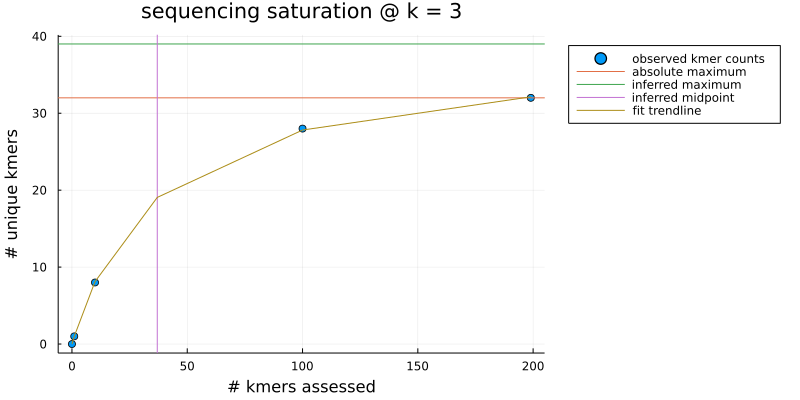

(k, predicted_saturation) = (3, 1.21875)
  0.000193 seconds (748 allocations: 82.734 KiB)

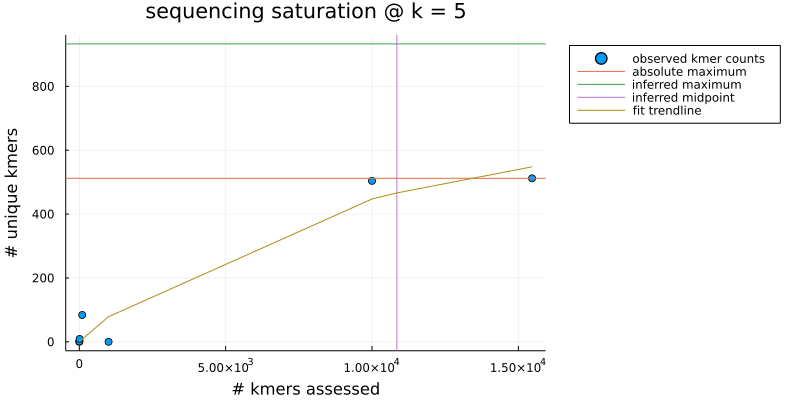


(k, predicted_saturation) = (5, 1.822265625)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


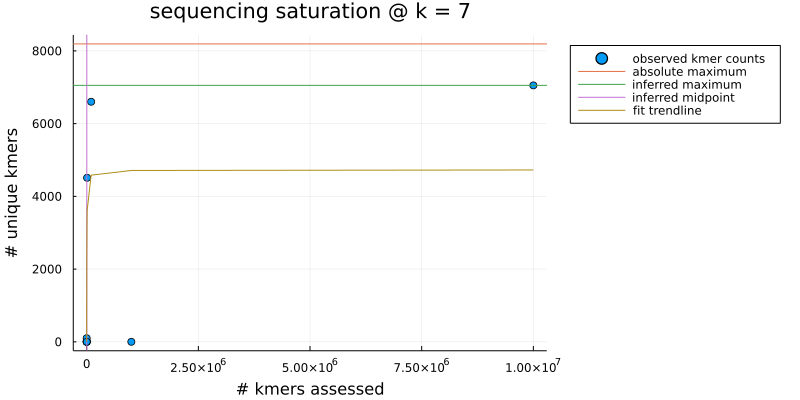

  0.000292 seconds (968 allocations: 116.016 KiB)
(k, predicted_saturation) = (7, 0.8607177734375)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


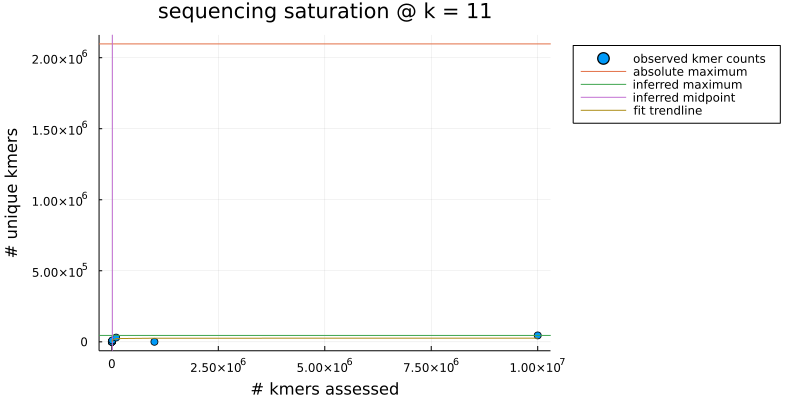

  0.000182 seconds (463 allocations: 53.984 KiB)
(k, predicted_saturation) = (11, 0.02144336700439453)
chosen k = 11


In [13]:
Mycelia.assess_kmer_saturation(fastxs, outdir="$(covid_genomes_md5)-saturation")

Need to offload loads of methods from Mycelia.jl and replace with new algorithms from notebooks

For 10_000 covid genomes
```
 Warning: Package Mycelia does not have FileIO in its dependencies:
│ - If you have Mycelia checked out for development and have
│   added FileIO as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Mycelia
└ Loading FileIO into Mycelia from project dependency, future warnings for Mycelia are suppressed.

args = Dict{String, Any}("fastx" => ["/home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta"], "k" => 11, "out" => "/home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta.11.jld2")

[ Info: counting kmers

 89.159020 seconds (2.65 M allocations: 18.019 GiB, 1.01% gc time, 1.46% compilation time)

[ Info: initializing graph
[ Info: adding node metadata
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04:15:20
[ Info: determing # of records in fastx file
Progress: 100%|█████████████████████████████████████████| Time: 0:16:49

parsed_args = Dict{String, Any}("construct" => Dict{String, Any}("fastx" => ["/home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta"], "k" => 11, "out" => "/home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta.11.jld2"), "%COMMAND%" => "construct")
f = Mycelia.construct
1175.915877 seconds (161.21 k allocations: 10.768 MiB)

Process(`julia /home/jupyter-cjprybol/.julia/dev/Mycelia/bin/mycelia.jl construct --k 11 --fastx /home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta --out /home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta.11.jld2`, ProcessExited(0))
```

In [14]:
# k = 3
# k = 5
# 10 genomes - 92.283553 seconds (2.06 k allocations: 40.953 KiB)
# 100 genomes - 283.205233 seconds (5.89 k allocations: 101.141 KiB)
# 1000 genomes - ?
# 10_000 genomes - ?

k = 11

out = "$(covid_genomes_md5).$(k).jld2"
if !isfile(out)
    @time run(`julia $(executable) construct --k $(k) --fastx $(fastxs) --out $(out)`)
end

In [15]:
# gfa_file = "$(out).gfa"
# if !isfile(gfa_file)    
#     @time run(`julia $(executable) convert --in $(out) --out $(gfa_file)`)
# end

In [16]:
# run(`/home/jupyter-cjprybol/software/bin/Bandage image $(gfa_file) $(gfa_file).svg --depwidth 1 --deppower 1`)

In [17]:
graph = FileIO.load(out)["graph"]

{177324, 204718} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

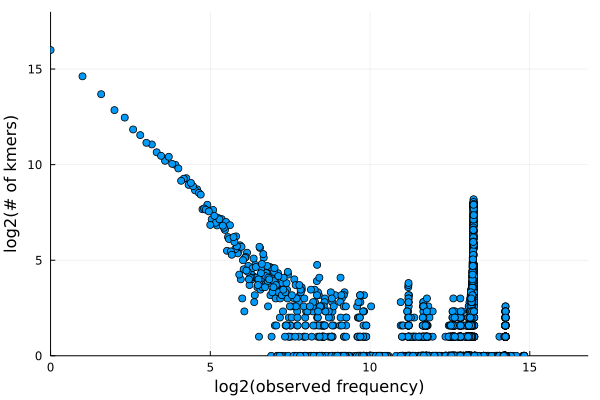

In [18]:
Mycelia.plot_kmer_frequency_spectra(collect(values(graph.gprops[:kmer_counts])))

The final genome of sequenced SARS-CoV-2 consists of a single, positive-stranded RNA that is 29,811 nucleotides long, broken down as follows: 8,903 (29.86%) adenosines, 5,482 (18.39%) cytosines, 5,852 (19.63%) guanines, and 9,574 (32.12%) thymines.

In [23]:
threshold = 2^13
# vertices_to_keep = findall(v -> graph.vprops[v][:count] >= threshold, Graphs.vertices(graph))

8192

In [24]:
# # [kmer count options]
# #      -in                                     (1 arg) :    reads file  [default '']
# #      -kmer-size                              (1 arg) :    size of a kmer  [default '31']
# #      -abundance-min                          (1 arg) :    min abundance threshold for solid kmers  [default '2']
# #      -abundance-max                          (1 arg) :    max abundance threshold for solid kmers  [default '2147483647']
# #      -solidity-custom                        (1 arg) :    when solidity-kind is custom, specifies list of files where kmer must be present  [default '']
# #      -max-memory                             (1 arg) :    max memory (in MBytes)  [default '5000']
# #      -max-disk                               (1 arg) :    max disk   (in MBytes)  [default '0']
# #      -out                                    (1 arg) :    output file  [default '']
# #      -out-dir                                (1 arg) :    output directory  [default '.']
# #      -out-tmp                                (1 arg) :    output directory for temporary files  [default '.']
# #      -out-compress                           (1 arg) :    h5 compression level (0:none, 9:best)  [default '0']
# #      -storage-type                           (1 arg) :    storage type of kmer counts ('hdf5' or 'file')  [default 'hdf5']
# #      -histo2D                                (1 arg) :    compute the 2D histogram (with first file = genome, remaining files = reads)  [default '0']
# #      -histo                                  (1 arg) :    output the kmer abundance histogram  [default '0']
# # pretty fast! Just a few minutes
bcalm_base = "$(covid_genomes_md5).$(k).min-$(threshold).bcalm"
@time run(`bcalm -in $(join(fastxs, ' ')) -kmer-size $(k) -abundance-min $(threshold) -out $(bcalm_base)`)

setting storage type to hdf5


[Approximating frequencies of minimizers ]  100  %   elapsed:   0 min 0  sec   remaining:   0 min 0  sec   cpu: 107.7 %   mem: [  37,   37, 1029] MB 
[DSK: Collecting stats on covid-genome...]  100  %   elapsed:   0 min 0  sec   remaining:   0 min 0  sec   cpu:  93.5 %   mem: [  53,   53, 1029] MB 
[DSK: nb solid kmers: 28589              ]  100  %   elapsed:   1 min 18 sec   remaining:   0 min 0  sec   cpu: 192.1 %   mem: [ 141, 1927, 2167] MB 


bcalm_algo params, prefix:/home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta.11.min-8192.bcalm.unitigs.fa k:11 a:8192 minsize:10 threads:2 mintype:1
DSK used 1 passes and 2 partitions
prior to queues allocation                      17:44:38     memory [current, maxRSS]: [ 128, 2167] MB 
Starting BCALM2                                 17:44:38     memory [current, maxRSS]: [ 128, 2167] MB 

Iterated 14547 kmers, among them 14547 were doubled


[Iterating DSK partitions                ]  0    %   elapsed:   0 min 0  sec   remaining:   0 min 0  sec


In this superbucket (containing 12760 active minimizers),
                  sum of time spent in lambda's: 65.8 msecs
                                 longest lambda: 5.3 msecs
         tot time of best scheduling of lambdas: 65.8 msecs
                       best theoretical speedup: 12.4x
Done with partition 0                           17:44:38     memory [current, maxRSS]: [ 152, 2167] MB 

Iterated 14042 kmers, among them 14041 were doubled
Loaded 3639 doubled kmers for partition 1


[Iterating DSK partitions                ]  100  %   elapsed:   0 min 0  sec   remaining:   0 min 0  sec
[Building BooPHF]  100  %   elapsed:   0 min 0  sec   remaining:   0 min 0  sec


In this superbucket (containing 14555 active minimizers),
                  sum of time spent in lambda's: 81.6 msecs
                                 longest lambda: 5.7 msecs
         tot time of best scheduling of lambdas: 81.6 msecs
                       best theoretical speedup: 14.3x
Done with partition 1                           17:44:39     memory [current, maxRSS]: [ 152, 2167] MB 
Number of sequences in glue: 31598
Number of pre-tips removed : 0
Buckets compaction and gluing           : 0.2 secs
Within that, 
                                 creating buckets from superbuckets: 0.0 secs
                      bucket compaction (wall-clock during threads): 0.1 secs

                within all bucket compaction threads,
                       adding nodes to subgraphs: 0.0 secs
         subgraphs constructions and compactions: 0.0 secs
                  compacted nodes redistribution: 0.1 secs
Sum of CPU times for bucket compactions: 0.2 secs
BCALM total wallclock (excl kmer c

[Building BooPHF]  100  %   elapsed:   0 min 0  sec   remaining:   0 min 0  sec


Allowed 95 MB memory for buffers                17:44:39     memory [current, maxRSS]: [ 156, 2167] MB 
Disk partitioning of glue                       17:44:39     memory [current, maxRSS]: [ 156, 2167] MB 
Done disk partitioning of glue                  17:44:39     memory [current, maxRSS]: [ 109, 2167] MB 
Top 10 glue partitions by size:
Glue partition 351 has 165 sequences 
Glue partition 719 has 115 sequences 
Glue partition 52 has 109 sequences 
Glue partition 1691 has 109 sequences 
Glue partition 1100 has 100 sequences 
Glue partition 686 has 98 sequences 
Glue partition 85 has 97 sequences 
Glue partition 827 has 97 sequences 
Glue partition 635 has 97 sequences 
Glue partition 27 has 94 sequences 
Glueing partitions                              17:44:39     memory [current, maxRSS]: [ 109, 2167] MB 
Gluing partition 0 (size: 0 MB)                 17:44:39     memory [current, maxRSS]: [ 109, 2167] MB 
Gluing partition 20 (size: 0 MB)                17:44:39     memory [curre

Process(`bcalm -in /home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta -kmer-size 11 -abundance-min 8192 -out /home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta.11.min-8192.bcalm`, ProcessExited(0))

In [25]:
# need to convert to GFA
run(`python $(homedir())/software/bin/convertToGFA.py $(bcalm_base).unitigs.fa $(bcalm_base).unitigs.fa.gfa $(k)`)

GFA file open
done


Process(`python /home/jupyter-cjprybol/software/bin/convertToGFA.py /home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta.11.min-8192.bcalm.unitigs.fa /home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta.11.min-8192.bcalm.unitigs.fa.gfa 11`, ProcessExited(0))

In [26]:
run(`/home/jupyter-cjprybol/software/bin/Bandage image $(bcalm_base).unitigs.fa.gfa $(bcalm_base).unitigs.fa.gfa.svg --depwidth 1 --deppower 1`)

Process(`/home/jupyter-cjprybol/software/bin/Bandage image /home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta.11.min-8192.bcalm.unitigs.fa.gfa /home/jupyter-cjprybol/workspace/2022-01-15-minimal-genome/covid-genomes.1639a53c979d07066ff86ecdca2c5135.fasta.11.min-8192.bcalm.unitigs.fa.gfa.svg --depwidth 1 --deppower 1`, ProcessExited(0))

In [ ]:
# thresholded_subgraph, vmap = Graphs.induced_subgraph(graph, vertices_to_keep)

In [ ]:
# thresholded_subgraph_file = replace(out, ".jld2" => ".threshold-$(threshold).jld2")

In [ ]:
# FileIO.save(thresholded_subgraph_file, Dict("graph" => thresholded_subgraph))

In [ ]:
# reduce and simplify

In [ ]:
# gfa_file = "$(thresholded_subgraph_file).gfa"
# if !isfile(gfa_file)
#     @time run(`julia $(executable) convert --in $(thresholded_subgraph_file) --out $(gfa_file)`)
# end

In [ ]:
# run(`/home/jupyter-cjprybol/software/bin/Bandage image $(gfa_file) $(gfa_file).svg --depwidth 1 --deppower 1`)

In [ ]:
# Bifrost x.y

# Highly parallel construction, indexing and querying of colored and compacted de Bruijn graphs

# Usage: Bifrost [COMMAND] [PARAMETERS]

# [COMMAND]:

#    build                   Build a compacted de Bruijn graph, with or without colors
#    update                  Update a compacted (possible colored) de Bruijn graph with new sequences
#    query                   Query a compacted (possible colored) de Bruijn graph

# [PARAMETERS]: build

#    > Mandatory with required argument:

#    -s, --input-seq-file     Input sequence file (FASTA/FASTQ possibly gzipped)
#                             Multiple files can be provided as a list in a TXT file (one file per line)
#                             K-mers with exactly 1 occurrence in the input sequence files will be discarded
#    -r, --input-ref-file     Input reference file (FASTA/FASTQ possibly gzipped and GFA)
#                             Multiple files can be provided as a list in a TXT file (one file per line)
#                             All k-mers of the input reference files are used
#    -o, --output-file        Prefix for output file(s)

#    > Optional with required argument:

#    -t, --threads            Number of threads (default is 1)
#    -k, --kmer-length        Length of k-mers (default is 31)
#    -m, --min-length         Length of minimizers (default is 23)
#    -b, --bloom-bits         Number of Bloom filter bits per k-mer with 1+ occurrences in the input files (default is 14)
#    -B, --bloom-bits2        Number of Bloom filter bits per k-mer with 2+ occurrences in the input files (default is 14)
#    -l, --load-mbbf          Input Blocked Bloom Filter file, skips filtering step (default is no input)
#    -w, --write-mbbf         Output Blocked Bloom Filter file (default is no output)
#    -u, --chunk-size         Read chunk size per thread (default is 64)

#    > Optional with no argument:

#    -c, --colors             Color the compacted de Bruijn graph (default is no coloring)
#    -y, --keep-mercy         Keep low coverage k-mers connecting tips
#    -i, --clip-tips          Clip tips shorter than k k-mers in length
#    -d, --del-isolated       Delete isolated contigs shorter than k k-mers in length
#    -a, --fasta              Output file is in FASTA format (only sequences) instead of GFA
#    -v, --verbose            Print information messages during execution

Find maximum likelihood path through the genome

### Bacteria: Mycobacterium spp.

Find all COVID-19 submissions in NCBI refseq and genbank. Start with refseq

In [ ]:
# # db = "refseq"
# db = "genbank"
# ncbi_summary_url = "https://ftp.ncbi.nih.gov/genomes/$(db)/assembly_summary_$(db).txt"
# ncbi_summary_outfile = basename(ncbi_summary_url)
# if !isfile(ncbi_summary_outfile)
#     download(ncbi_summary_url, ncbi_summary_outfile)
# end
# ncbi_summary_table = DataFrames.DataFrame(uCSV.read(ncbi_summary_outfile, header=2, delim='\t')...)

Build pangenome graph

Find maximum likelihood path through the genome

### Eukaryote: S. cerevisae

Find all COVID-19 submissions in NCBI refseq and genbank. Start with refseq

Build pangenome graph

Find maximum likelihood path through the genome

## Results

## References

https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02130-z

https://www.science.org/doi/10.1126/science.aaf4557

http://syntheticyeast.org/software-development/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3370935/

https://en.wikipedia.org/wiki/Minimal_genome

https://www.science.org/doi/10.1126/science.aad6253

https://www.pnas.org/content/103/2/425